## Import Package

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Load Dataset

In [2]:
#load dataset with additional rule --> turn any possible nan value into NaN
flight = pd.read_csv('flight.csv', na_values=['.', '', ' ', '?', '-'])
flight.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,NaN,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,...,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,NaN,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39


## Data Understanding

In [3]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          62988 non-null  int64  
 1   FFP_DATE           62988 non-null  object 
 2   FIRST_FLIGHT_DATE  62988 non-null  object 
 3   GENDER             62985 non-null  object 
 4   FFP_TIER           62988 non-null  int64  
 5   WORK_CITY          59972 non-null  object 
 6   WORK_PROVINCE      58548 non-null  object 
 7   WORK_COUNTRY       62962 non-null  object 
 8   AGE                62568 non-null  float64
 9   LOAD_TIME          62988 non-null  object 
 10  FLIGHT_COUNT       62988 non-null  int64  
 11  BP_SUM             62988 non-null  int64  
 12  SUM_YR_1           62437 non-null  float64
 13  SUM_YR_2           62850 non-null  float64
 14  SEG_KM_SUM         62988 non-null  int64  
 15  LAST_FLIGHT_DATE   62988 non-null  object 
 16  LAST_TO_END        629

In [4]:
#checking dataframe shape
print('Total row:', flight.shape[0], '\nTotal features:', flight.shape[1])

Total row: 62988 
Total features: 23


**Observation:** 
1. At a glance, we can see that there are quite many missing value found on the dataset, especially on `WORK_CITY` and `WORK_PROVINCE`
2. Features are too many, we need to drop unnecessary ones
3. We might need to change dtypes of `FFP_DATE`, `FIRST_FLIGHT_DATE`, and `LAST_FLIGHT_DATE` to *datetime*

## Data Preprocessing


Since there are too many features available, we need to to drop features that we think unnecessary

How do we decide that? by ***Googling***, of course!

So after some research, I found that we only need to find 5 insights from this dataset, which are:

1. **Length of customer membership (L)**: Interval between joining and current time. `Formula = LOAD_TIME - FFP_DATE`
2. **Consumption interval (R)**: The interval between the latest consumption time and the current time -> `LAST_TO_END`
3. **Consumption
frequency (F)**: Number of rides in the observation time window -> `FLIGHT_COUNT`
4. **Total flight miles (M)**: Number of miles flown within the observation time window -> `SEG_KM_SUM`
5. **Mean value of cabin
discount coefficient (C)**: The coefficient of the average discount that customers get -> `avg_discount`

Based on that, now we can drop all the columns we don't need

In [5]:
#create copy df
data_ori = flight.copy()

#drop unnecessary columns
flight = flight.drop(['MEMBER_NO', 'FIRST_FLIGHT_DATE', 'GENDER', 'FFP_TIER',
                      'SUM_YR_1', 'SUM_YR_2','WORK_CITY', 'WORK_PROVINCE', 'WORK_COUNTRY', 
                      'AGE', 'BP_SUM','LAST_FLIGHT_DATE', 'AVG_INTERVAL', 'MAX_INTERVAL',
                      'EXCHANGE_COUNT', 'Points_Sum', 'Point_NotFlight'], axis = 1)

flight.head()

,FFP_DATE,LOAD_TIME,FLIGHT_COUNT,SEG_KM_SUM,LAST_TO_END,avg_discount
0,11/2/2006,3/31/2014,210,580717,1,0.961639
1,2/19/2007,3/31/2014,140,293678,7,1.252314
2,2/1/2007,3/31/2014,135,283712,11,1.254676
3,8/22/2008,3/31/2014,23,281336,97,1.090870
4,4/10/2009,3/31/2014,152,309928,5,0.970658


In [6]:
print('Total row:', flight.shape[0], '\nTotal features:', flight.shape[1])

Total row: 62988 
Total features: 6


### Missing Value

In [7]:
#check missing value
flight.isna().sum()

FFP_DATE        0
LOAD_TIME       0
FLIGHT_COUNT    0
SEG_KM_SUM      0
LAST_TO_END     0
avg_discount    0
dtype: int64

All clear, we can continue

### Duplicated Value

In [8]:
#check duplicated value
flight.duplicated().sum()

93

In [9]:
#show duplicated data
duplicate = flight[flight.duplicated()]
duplicate

,FFP_DATE,LOAD_TIME,FLIGHT_COUNT,SEG_KM_SUM,LAST_TO_END,avg_discount
7742,10/31/2010,3/31/2014,4,30398,130,0.860000
8107,10/30/2011,3/31/2014,3,36696,130,0.690000
13293,10/26/2012,3/31/2014,2,24464,230,0.720000
17157,6/21/2012,3/31/2014,2,20272,626,0.700000
17658,11/16/2008,3/31/2014,2,24464,273,0.565000
...,...,...,...,...,...,...
62082,11/6/2012,3/31/2014,2,1522,495,0.550000
62085,1/28/2008,3/31/2014,2,1007,158,0.831122
62317,9/19/2012,3/31/2014,2,1902,560,0.400000
62552,6/1/2012,3/31/2014,2,2710,659,0.250000


In [10]:
#drop duplicated data
flight = flight.drop_duplicates()

In [11]:
#check again
flight.duplicated().sum()

0

All clear now, so we can continue

### Feature Engineering

Here we will make 2 new features, which are `MEMBERSHIP_LENGTH (M)` and `avg_fare_per_km`.

Afterwards, we're going to drop columns `FFP_DATE`, `LOAD_TIME`, and `SUM_YR_1`

In [12]:
#check info dataframe
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62895 entries, 0 to 62987
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FFP_DATE      62895 non-null  object 
 1   LOAD_TIME     62895 non-null  object 
 2   FLIGHT_COUNT  62895 non-null  int64  
 3   SEG_KM_SUM    62895 non-null  int64  
 4   LAST_TO_END   62895 non-null  int64  
 5   avg_discount  62895 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ MB


In [13]:
#change data type object to datetime
flight['FFP_DATE'] = pd.to_datetime(flight['FFP_DATE'])
flight['LOAD_TIME'] = pd.to_datetime(flight['LOAD_TIME'])

In [14]:
#create 'MEMBERSHIP_LENGTH' in month features 
flight['membership_length (M)'] = (flight['LOAD_TIME'] - flight['FFP_DATE'])/np.timedelta64(1,'M')

#show dataframe
flight.head()

,FFP_DATE,LOAD_TIME,FLIGHT_COUNT,SEG_KM_SUM,LAST_TO_END,avg_discount,membership_length (M)
0,2006-11-02,2014-03-31,210,580717,1,0.961639,88.905316
1,2007-02-19,2014-03-31,140,293678,7,1.252314,85.324134
2,2007-02-01,2014-03-31,135,283712,11,1.254676,85.915522
3,2008-08-22,2014-03-31,23,281336,97,1.090870,67.253948
4,2009-04-10,2014-03-31,152,309928,5,0.970658,59.664469


In [15]:
#drop features 'FFP_DATE', 'LOAD_TIME', and 'SUM_YR_1'
flight = flight.drop(['FFP_DATE', 'LOAD_TIME'], axis='columns')

#rename features
flight.rename(columns={'FLIGHT_COUNT': 'consumption_frequency', 'LAST_TO_END': 'consumption_interval', 'SEG_KM_SUM': 'total_flight_miles'}, inplace=True)

#show updated dataframe
flight.head()

,consumption_frequency,total_flight_miles,consumption_interval,avg_discount,membership_length (M)
0,210,580717,1,0.961639,88.905316
1,140,293678,7,1.252314,85.324134
2,135,283712,11,1.254676,85.915522
3,23,281336,97,1.090870,67.253948
4,152,309928,5,0.970658,59.664469


In [16]:
#change order of features
data = flight.reindex(columns = ['membership_length (M)','consumption_interval','consumption_frequency', 
                                 'total_flight_miles', 'avg_discount'])

data.head()

,membership_length (M),consumption_interval,consumption_frequency,total_flight_miles,avg_discount
0,88.905316,1,210,580717,0.961639
1,85.324134,7,140,293678,1.252314
2,85.915522,11,135,283712,1.254676
3,67.253948,97,23,281336,1.090870
4,59.664469,5,152,309928,0.970658


### Statistical Summary

In [17]:
#check dataframe again
data.describe()

,membership_length (M),consumption_interval,consumption_frequency,total_flight_miles,avg_discount
count,62895.000000,62895.000000,62895.000000,62895.000000,62895.000000
mean,48.828653,175.652484,11.853422,17140.638922,0.721648
std,27.834376,183.429054,14.055087,20970.426476,0.185378
min,11.992033,1.000000,2.000000,368.000000,0.000000
25%,24.115485,29.000000,3.000000,4754.000000,0.612272
50%,41.791413,107.000000,7.000000,10018.000000,0.711996
75%,71.623647,266.000000,15.000000,21289.000000,0.809503
max,112.922237,731.000000,213.000000,580717.000000,1.500000


**Observation:** 
1. The `avg discount` column has `min=0`, which is quite reasonable on loyalty program since there are cases where members never receive a discount on their flights simply because they haven't reached a certain threshold

In [18]:
#define rows to drop
rows_to_drop = data[data['avg_discount'] > 1]

#drop rows with avg_discount > 1
data = data.drop(rows_to_drop.index)
data

,membership_length (M),consumption_interval,consumption_frequency,total_flight_miles,avg_discount
0,88.905316,1,210,580717,0.961639
4,59.664469,5,152,309928,0.970658
5,73.627795,79,92,294585,0.967692
6,96.297665,1,101,287042,0.965347
7,47.705292,3,73,287230,0.962070
...,...,...,...,...,...
62983,34.366209,297,2,1134,0.000000
62984,48.756648,89,4,8016,0.000000
62985,96.034826,29,2,2594,0.000000
62986,13.733342,400,2,3934,0.000000


### Numeric Distribution and Outlier Handling

In [19]:
#create nwe backup of data
df = data.copy()

df.head()

,membership_length (M),consumption_interval,consumption_frequency,total_flight_miles,avg_discount
0,88.905316,1,210,580717,0.961639
4,59.664469,5,152,309928,0.970658
5,73.627795,79,92,294585,0.967692
6,96.297665,1,101,287042,0.965347
7,47.705292,3,73,287230,0.962070


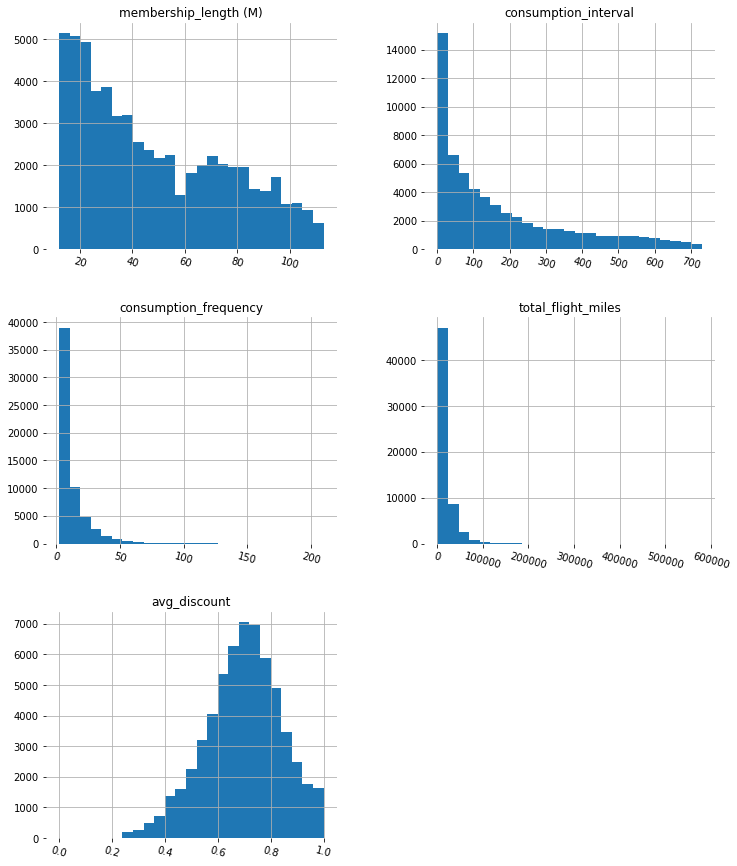

In [20]:
#show features distribution
h = data.hist(bins=25,figsize=(12,15),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)

[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

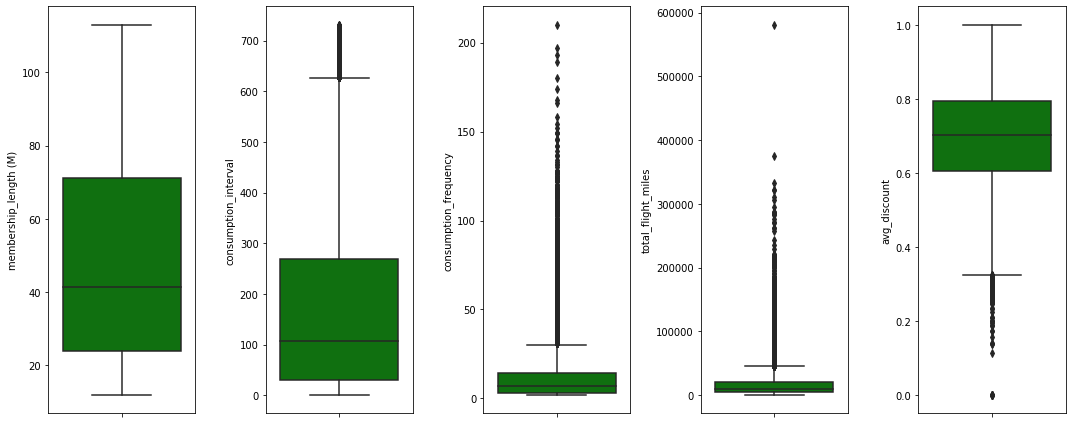

In [21]:
features = list(df)

#checking outlier
plt.figure(figsize=(15, 6))

for i in range(0, len(features)):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=data[features[i]],color='green',orient='v')
    plt.tight_layout()

**Observation:** Except for column `membership_length`, there are quite many outliers found on the dataset, so we need to handle (reduce/drop) it before modeling

In [22]:
#pulling outliers
outlier_features =['consumption_interval','consumption_frequency', 'total_flight_miles', 'avg_discount']
for i in outlier_features:
    df[i] = np.log(df[i]+1)

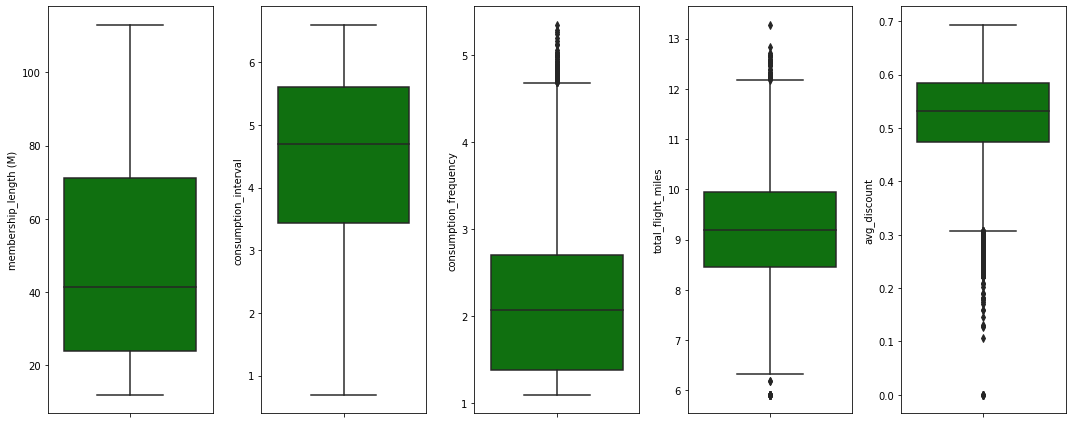

In [23]:
#check again
plt.figure(figsize=(15, 6))

for i in range(0, len(features)):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=df[features[i]],color='green',orient='v')
    plt.tight_layout()

In [24]:
data.describe()

,membership_length (M),consumption_interval,consumption_frequency,total_flight_miles,avg_discount
count,59950.000000,59950.000000,59950.000000,59950.000000,59950.000000
mean,48.490930,176.783286,11.668324,16788.611543,0.695952
std,27.707552,183.717045,13.761917,20345.126042,0.143955
min,11.992033,1.000000,2.000000,368.000000,0.000000
25%,23.951210,30.000000,3.000000,4718.000000,0.605876
50%,41.331444,108.000000,7.000000,9890.000000,0.703477
75%,71.229389,269.000000,14.000000,20912.500000,0.794534
max,112.922237,731.000000,210.000000,580717.000000,1.000000


In [25]:
#outlier handling
fil_ent = np.array([True] * len(df))

for col in ['consumption_frequency', 'total_flight_miles', 'avg_discount']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1

    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    fil_ent = ((df[col] >= low_limit) & (df[col] <= high_limit)) & fil_ent
    
df = df[fil_ent].reset_index()

In [26]:
df = df.drop('index', axis=1)
df.head()

,membership_length (M),consumption_interval,consumption_frequency,total_flight_miles,avg_discount
0,45.701144,1.945910,4.442651,12.137912,0.661673
1,76.486170,4.488636,3.496508,12.114856,0.665082
2,63.508491,2.079442,3.433987,12.123750,0.656745
3,43.532721,3.135494,3.135494,12.045945,0.689367
4,12.517711,3.401197,3.178054,12.038984,0.690914


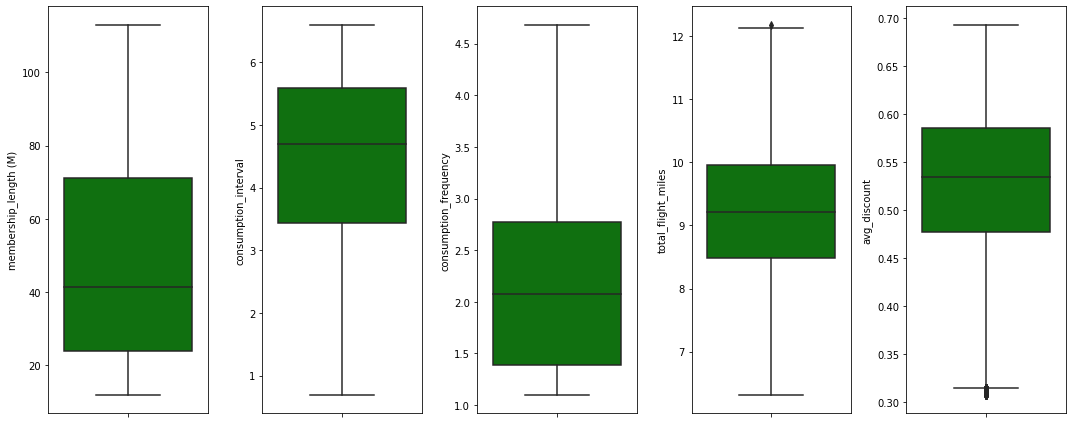

In [27]:
#check again
plt.figure(figsize=(15, 6))

for i in range(0, len(features)):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=df[features[i]],color='green',orient='v')
    plt.tight_layout()

**Result:** Outlier reduced significantly

### Correlation Matrix

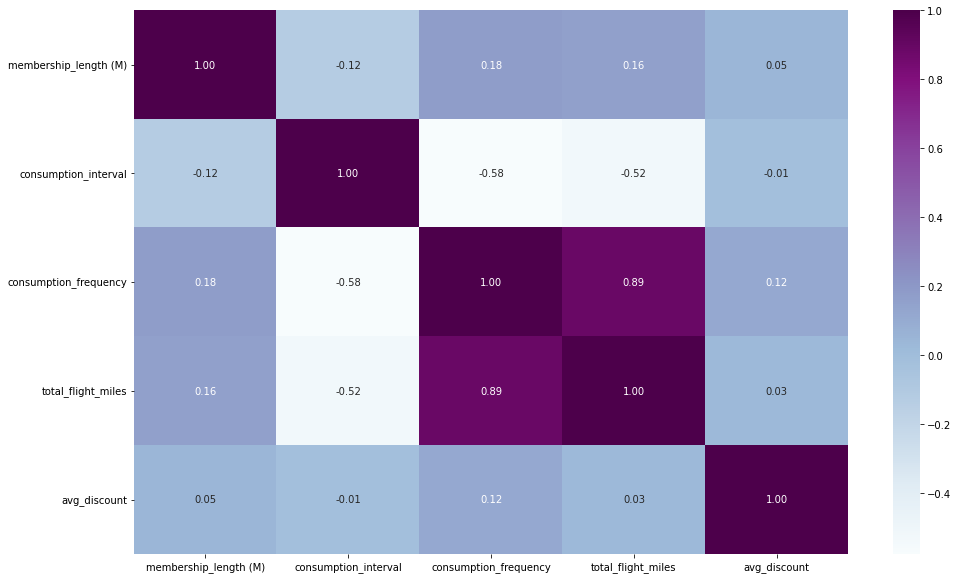

In [28]:
corr_ = df.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")

### Scaling

In [29]:
#scaling
sc_data = StandardScaler()
data_std = sc_data.fit_transform(df.astype(float))

## Modeling

### Find the best n_cluster

Before clustering, we need to find the best K-means for clustering using Inertia and/or Silhoutte Score

#### Inertia

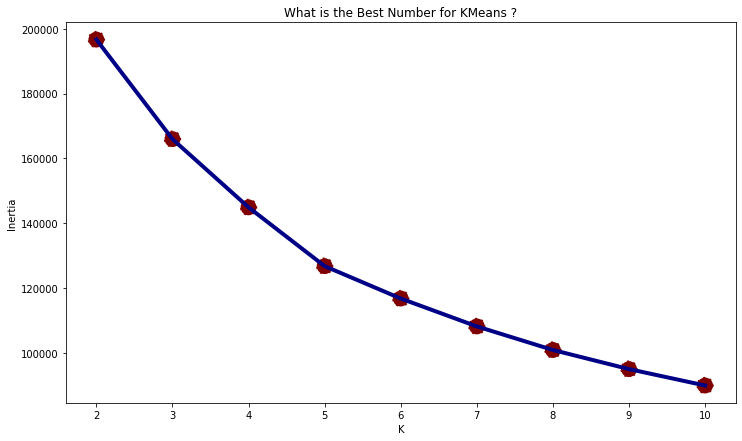

In [30]:
#using inertia
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(data_std)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 7))
plt.title('What is the Best Number for KMeans ?')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.xticks(range(2,11))

# plt.plot(inertia)
sns.lineplot(x=range(2, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 11), y=inertia, s=300, color='#800000',  linestyle='--')

**Best n_cluster = Hard to tell**

#### Silhoutte Score

In [31]:
range_n_clusters = list(range(2,11))
print(range_n_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


In [32]:
#using silhoutte score
arr_silhouette_score_euclidean = []

for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i).fit(data_std)
    preds = kmeans.predict(data_std)
    
    score_euclidean = silhouette_score(data_std, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

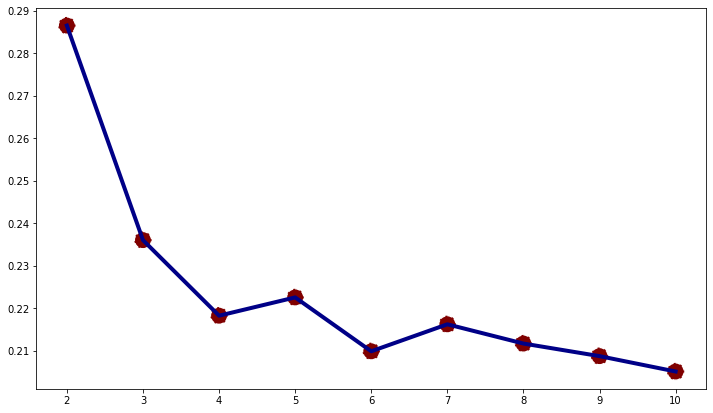

In [33]:
# plotting
plt.figure(figsize=(12, 7))

sns.lineplot(x=range(2, 11), y=arr_silhouette_score_euclidean, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 11), y=arr_silhouette_score_euclidean, s=300, color='#800000',  linestyle='--')

**Best n cluster= 4 or 6** | lets just go with **4**

### K-Means clustering

In [34]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(data_std)

In [35]:
df_data_std = pd.DataFrame(data=data_std, columns=list(data))
df_data_std.head()

,membership_length (M),consumption_interval,consumption_frequency,total_flight_miles,avg_discount
0,-0.103489,-1.693972,2.776657,2.903625,1.645085
1,1.008920,0.049455,1.622209,2.880607,1.687238
2,0.539975,-1.602416,1.545924,2.889487,1.584160
3,-0.181844,-0.878330,1.181715,2.811806,1.987488
4,-1.302563,-0.696150,1.233644,2.804857,2.006615


In [36]:
#check shape of both df if equal or not
print('data shape:', df.shape)
print('df_data_std shape:', df_data_std.shape)

data shape: (58843, 5)
df_data_std shape: (58843, 5)


In [37]:
df.head(5)

,membership_length (M),consumption_interval,consumption_frequency,total_flight_miles,avg_discount
0,45.701144,1.945910,4.442651,12.137912,0.661673
1,76.486170,4.488636,3.496508,12.114856,0.665082
2,63.508491,2.079442,3.433987,12.123750,0.656745
3,43.532721,3.135494,3.135494,12.045945,0.689367
4,12.517711,3.401197,3.178054,12.038984,0.690914


In [38]:
df_data_std['clusters'] = kmeans.labels_
df['clusters'] = kmeans.labels_
#data['clusters'] = kmeans.labels_

In [40]:
data.shape

(59950, 5)

In [41]:
#dataframe to show members of each  (data)
cluster_count = pd.DataFrame(df['clusters'].value_counts()).reset_index().rename(columns={'clusters':'member','index':'clusters'})
cluster_count

,clusters,member
0,1,17379
1,3,15383
2,2,14252
3,0,11829


In [43]:
display(df.groupby('clusters').agg(['mean']))

,membership_length (M),consumption_interval,consumption_frequency,total_flight_miles,avg_discount
,mean,mean,mean,mean,mean
clusters,,,,,
0,82.411198,3.357835,2.982873,10.170799,0.540785
1,45.951991,5.357677,1.551874,8.428173,0.591677
2,42.773516,5.108130,1.591047,8.642326,0.433290
3,30.856599,3.526531,2.768184,9.955444,0.536321


## Insight

In [42]:
#using PCA for easier visualization
pca = PCA(n_components=2)

pca.fit(data_std)
pcs = pca.transform(data_std)

data_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
data_pca['clusters'] = df['clusters']
data_pca.head()

,PC 1,PC 2,clusters
0,4.335032,0.803552,0
1,2.988021,1.591226,0
2,3.653596,1.058324,0
3,2.924355,1.238264,3
4,2.648125,0.813158,3


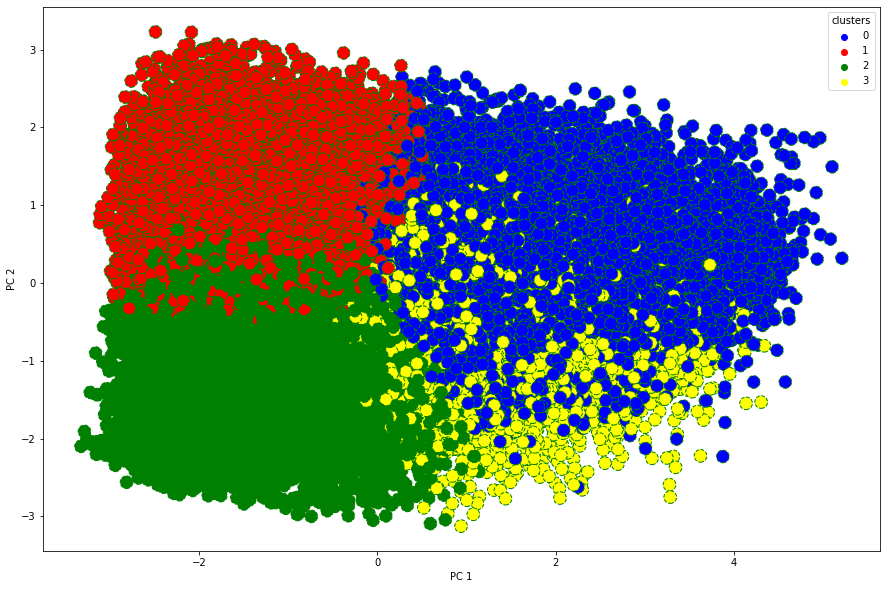

In [45]:
#visualization with PCA
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="clusters",
    edgecolor='green',
    linestyle='--',
    data=data_pca,
    palette=['blue','red','green','yellow'],
    s=160,
    ax=ax
)

In [46]:
#dataframe to show members of each cluster (df)
cluster_count_one = pd.DataFrame(df['clusters'].value_counts()).reset_index().rename(columns={'clusters':'member','index':'clusters'})
cluster_count_one

,clusters,member
0,1,17379
1,3,15383
2,2,14252
3,0,11829


In [47]:
display(df.groupby('clusters').agg(['mean']))

,membership_length (M),consumption_interval,consumption_frequency,total_flight_miles,avg_discount
,mean,mean,mean,mean,mean
clusters,,,,,
0,82.411198,3.357835,2.982873,10.170799,0.540785
1,45.951991,5.357677,1.551874,8.428173,0.591677
2,42.773516,5.108130,1.591047,8.642326,0.433290
3,30.856599,3.526531,2.768184,9.955444,0.536321


**Insights:**


1. **Cluster 0** terdiri dari 17.402 orang merupakan pelanggan yang sudah berlangganan cukup lama (hampir 4 tahun), namun memiliki frekuensi terbang yang rendah, jarak tempuh total yang kecil, dan interval waktu penerbangan paling lama di antara kluster lain. Kendati demikian, kelompok pelanggan ini adalah yang paling banyak menerima diskon.

2. **Cluster 1** terdiri dari 12.067 orang merupakan pelanggan loyal yang sudah berlangganan lebih dari 5 tahun dan memiliki frekuensi terbang yang paling sering di antara kluster lain. Selain itu, jarak tempuh totalnya juga tercatat paling tinggi dengang interval waktu penerbangan paling cepat di antara kluster lain yang berarti bahwa pelanggan di cluster ini sangat sering melakukan penerbangan. Sementara untuk rata-rata diskon yang diterima, kluster ini termasuk sebagai penikmat diskon terbesar ke-2 setelah `cluster 0`.

3. **Cluster 2** terdiri dari 14.855 orang merupakan pelanggan yang kurang lebih memiliki ciri-ciri yang sama dengan `cluster 0`. Perbedaannya hanya terletak pada rata-rata diskon yang diterima dimana kluster ini tercatat sebagai kluster yang menerima rata-rata diskon paling rendah di antara semua kluster.

4. **Cluster 3** terdiri dari 15.642 orang merupakan pelanggan yang terbilang belum lama berlangganan (kurang lebih baru sekitar 2,5 tahun), namun memiliki frekuensi terbang yang cukup tinggi dengan total jarak tempuh yang besar pula. Selain itu, pelanggan juga tercatat memiliki interval waktu antar penerbangan yang rendah dan menerima rata-rata diskon yang tinggi, tertinggi ke-3 diantara 4 kluster yang ada.


**Rekomendasi**:

1. Berdasarkan ciri-cirinya, `cluster=0` dan `cluster=2` bisa dibilang merupakan low-value customer yang hanya berlangganan saja tapi jarang sekali melakukan penerbangan. Biasanya, mereka hanya melakukan penerbangan ketika ada diskon saja. Untuk jenis pelanggan seperti ini, rekomendasinya tetap perlu dimaintain dengan memberikan promo2 menarik. Namun, ketika hendak memberikan promo, sebaiknya fokus saja pada penawaran promo untuk jarak penerbangan sedang, karena selama ini pelanggan lebih banyak melakukan penerbangan jarak tempuh sedang. Dengan melakukan strategi ini, harapannya frekuensi terbang dari pelanggan `cluster=0` dan `cluster=2` bisa lebih meningkat kedepannya.

2. `cluster=1` merupakan kelompok pelanggan yang paling bagus untuk bisnis dan sangat perlu diperhatikan karena pelanggan ini sangat sering melakukan penerbangan dengan rata-rata jarak tempuh yg jauh dan interval antar penerbangan yang rendah. Selain itu, pelanggan ini juga terbilang loyal karena sudah berlanggan lebih dari 5 tahun. Rekomendasi tindakan untuk pelanggan dari segmen `cluster=1` adalah sebaiknya tawarkan opsi upgrade program berlangganan untuk mereka dengan benefit yang lebih baik dan ekslusif daripada program berlangganan biasa. Karena pelanggan ini tipe pelanggan yang setia, besar kemungkinan program langganan yang ditawarkan akan diterima oleh mereka selama benefit dan costnya masih masuk akal. Hal ini perlu didiskusikan lebih lanjut dengan tim marketing.

3. Terakhir, untuk pelanggan `cluster=3` rekomendasi tindakan yang perlu dilakukan adalah memperbanyak promo untuk penerbangan jarak sedang/jauh  dan kalau bisa tawarkan juga program berlangganan dengan periode panjang sekaligus dengan benefit yang menarik, misal program berlangganan langsung 3 tahun atau 5 tahun yang memberikan benefit seperti kuota 1-2 kali penerbangan gratis selama periode berlangganan dan bonus persentase diskon yang lebih banyak daripada pelanggan yang hanya berlanggan secara tahunan.